**1. Load and Inspect Data**




In [35]:
import pandas as pd
import numpy as np

train_data = pd.read_csv('/kaggle/input/ueba-dbscan-iforest/train_data.csv', encoding='latin1')

print("Train Data Shape:", train_data.shape)

print(train_data.head())


Train Data Shape: (528690, 10)
   id            account         group              IP  \
0   1  xiaojiawei@qq.com  ÈËÊÂÐÐÕþÖÐÐÄ    192.168.1.50   
1   2  xiaojiawei@qq.com  ÈËÊÂÐÐÕþÖÐÐÄ   192.168.31.46   
2   3  xiaojiawei@qq.com  ÈËÊÂÐÐÕþÖÐÐÄ     192.168.2.3   
3   4  xiaojiawei@qq.com  ÈËÊÂÐÐÕþÖÐÐÄ  192.168.145.30   
4   5  xiaojiawei@qq.com  ÈËÊÂÐÐÕþÖÐÐÄ  192.168.178.92   

                               url   port  vlan      switchIP            time  \
0                http://123.6.4.41  15788   700  129.30.06.37  2021/6/16 7:56   
1           http://104.192.108.154  12665   700  152.91.89.45  2021/6/28 7:58   
2              http://42.236.37.80  25551   700  129.30.06.37   2021/6/1 6:37   
3  http://uf-api6-client.ksord.com  18274   700    162.6.8.29   2021/5/5 8:18   
4           http://101.199.128.170  34572   700    162.0.1.84  2021/6/20 6:52   

      ret  
0  0.1149  
1  0.1801  
2  0.3690  
3  0.1532  
4  0.1449  


In [36]:
print("Total observations:", len(train_data))
print("Unique accounts:", train_data['account'].nunique())
print("Unique IPs:", train_data['IP'].nunique())
print("Unique URLs:", train_data['url'].nunique())
print("Unique switchIPs:", train_data['switchIP'].nunique())

Total observations: 528690
Unique accounts: 151
Unique IPs: 133
Unique URLs: 1319
Unique switchIPs: 133


In [37]:
# Convert 'time' column to datetime and sort by time
train_data['time'] = pd.to_datetime(train_data['time'],format='%Y/%m/%d %H:%M')
train_data = train_data.sort_values(by='time')


In [38]:
# Temporal range of the dataset
start_time = train_data['time'].min()
end_time = train_data['time'].max()


In [39]:
print(f"First observation: {start_time}\nLatest observation: {end_time}")
print("Total observations:", len(train_data))
print("Unique accounts:", train_data['account'].nunique())
print("Unique IPs:", train_data['IP'].nunique())
print("Unique URLs:", train_data['url'].nunique())
print("Unique switchIPs:", train_data['switchIP'].nunique())

First observation: 2021-04-30 18:05:00
Latest observation: 2021-06-29 15:58:00
Total observations: 528690
Unique accounts: 151
Unique IPs: 133
Unique URLs: 1319
Unique switchIPs: 133


**2. Filter Data to Select Specific Users**

In [40]:
# Select a subset of users
unique_users = train_data['account'].unique()
selected_users = np.random.choice(unique_users, 5, replace=False)
filtered_df = train_data[train_data['account'].isin(selected_users)]


In [41]:
print("Total observations:", len(filtered_df))
print("Unique accounts:", filtered_df['account'].nunique())
print("Unique IPs:", filtered_df['IP'].nunique())
print("Unique URLs:", filtered_df['url'].nunique())
print("Unique switchIPs:", filtered_df['switchIP'].nunique())


Total observations: 18565
Unique accounts: 5
Unique IPs: 124
Unique URLs: 894
Unique switchIPs: 124


**2.1 Filter Data to Select Specific Time Ranges**

In [42]:
# Define the time range
start_date = '2021-06-26'
end_date = '2021-06-29'

# Filter data within the time range
sample_df = filtered_df[filtered_df['time'].between(start_date, end_date)]
sample_df.set_index('time', inplace=True, drop=False)

In [43]:
print("Total observations:", len(sample_df))
print("Unique accounts:", sample_df['account'].nunique())
print("Unique IPs:", sample_df['IP'].nunique())
print("Unique URLs:", sample_df['url'].nunique())
print("Unique switchIPs:", sample_df['switchIP'].nunique())


Total observations: 993
Unique accounts: 5
Unique IPs: 84
Unique URLs: 338
Unique switchIPs: 81


In [44]:
sample_df.columns

Index(['id', 'account', 'group', 'IP', 'url', 'port', 'vlan', 'switchIP',
       'time', 'ret'],
      dtype='object')

In [45]:
sample_df = sample_df.drop(columns=['id', 'group', 'port', 'vlan','ret', 'switchIP'])

In [46]:
sample_df.shape

(993, 4)

In [47]:
# numerical_features = [feature for feature in filtered_df.columns if sample_df[feature].dtypes != 'O' and sample_df[feature].dtype in ['int64', 'float64']]
# discrete_features=[feature for feature in numerical_features if len(filtered_df[feature].unique())<15]
# continuous_feature=[feature for feature in numerical_features if feature not in discrete_features]


**Label Encoding for categorical variables**

In [48]:
categorical_features=[feature for feature in sample_df.columns if sample_df[feature].dtypes=='O']


In [49]:
categorical_features

['account', 'IP', 'url']

In [50]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
le = LabelEncoder()

# Apply LabelEncoder to each categorical column
for feature in categorical_features:
    sample_df[feature + '_encoded'] = le.fit_transform(sample_df[feature])
    

In [51]:
sample_df.head(3)

,account,IP,url,time,account_encoded,IP_encoded,url_encoded
time,,,,,,,
2021-06-26 00:33:00,hecailing@qq.com,10.52.0.6,http://www.bthgc.com,2021-06-26 00:33:00,0,5,306
2021-06-26 00:35:00,hecailing@qq.com,10.52.0.6,http://down.51cto.com,2021-06-26 00:35:00,0,5,142
2021-06-26 00:37:00,hecailing@qq.com,192.168.10.115,http://download.2345.com,2021-06-26 00:37:00,0,13,143


In [52]:
# Drop the original categorical columns 
sample_df = sample_df.drop(columns=categorical_features)
sample_df.head(5)

,time,account_encoded,IP_encoded,url_encoded
time,,,,
2021-06-26 00:33:00,2021-06-26 00:33:00,0,5,306
2021-06-26 00:35:00,2021-06-26 00:35:00,0,5,142
2021-06-26 00:37:00,2021-06-26 00:37:00,0,13,143
2021-06-26 00:37:00,2021-06-26 00:37:00,0,5,0
2021-06-26 00:40:00,2021-06-26 00:40:00,0,5,159


In [53]:
# **Feature Hashing for categorical variables**

# from sklearn.feature_extraction import FeatureHasher

# cols = sample_df[["account", "IP", "url"]]

# # Convert each value in the selected columns to a string
# cols = cols.map(str)

# # Convert selected columns to list of dictionaries
# data_dict = cols.to_dict(orient='records')

# # Initialize feature hasher
# hasher = FeatureHasher(n_features=10, input_type='string')
# hashed_features = hasher.fit_transform(data_dict).toarray()

# # Convert hashed features to DataFrame
# hashed_df = pd.DataFrame(hashed_features, columns=[f'feature_{i}' for i in range(hashed_features.shape[1])])

# # Combine the original DataFrame with hashed features
# result_df = pd.concat([cols.reset_index(), hashed_df], axis=1)

### **Pre-processing of Time column**

In [54]:
# Extract numerical features

sample_df['hour'] = sample_df['time'].dt.hour
sample_df['day_of_week'] = sample_df['time'].dt.day_of_week
sample_df['month'] = sample_df['time'].dt.month


In [55]:
sample_df.drop('time', axis=1, inplace=True)

In [56]:
sample_df.head(4)

,account_encoded,IP_encoded,url_encoded,hour,day_of_week,month
time,,,,,,
2021-06-26 00:33:00,0,5,306,0,5,6
2021-06-26 00:35:00,0,5,142,0,5,6
2021-06-26 00:37:00,0,13,143,0,5,6
2021-06-26 00:37:00,0,5,0,0,5,6


**4. Preprocess (Normalize) the Data**

In [57]:
from sklearn.preprocessing import StandardScaler

# Normalize data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(sample_df)


**DBSCAN algorithm**

In [58]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN
epsilon = 0.5
min_samples = 5
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
clusters = dbscan.fit_predict(scaled_data)

In [59]:
clusters

array([ 0,  1,  1,  1,  1,  1,  1,  2,  3,  4,  1,  1, -1,  1,  3,  1,  3,
        1,  1,  4,  1,  1,  1,  5,  4,  0,  1,  1, -1,  1,  0,  0,  1,  0,
        5,  2,  1,  4,  4,  2,  1,  3,  1,  1,  3,  1,  1,  1,  1,  1,  1,
        1,  1,  0,  1,  1,  1,  1,  5,  5,  1,  3,  1,  1,  1,  1,  1,  1,
        3,  4,  3,  3,  3,  1,  3,  3,  1,  3,  4,  1,  1,  1,  1,  1,  1,
        5,  1,  4,  1, -1,  5,  1,  1,  3,  0,  2,  0,  1,  1, -1,  1,  0,
        1,  2,  1,  1,  0,  1,  3,  3,  1,  5,  1, -1, -1,  6,  7,  7,  7,
        7,  7,  6,  6, -1,  6,  7,  6,  6,  7,  6,  7,  6,  6,  7,  7, -1,
        6,  6,  6,  7,  7,  6,  6,  7, -1,  6,  7,  7,  6, -1,  7,  6,  6,
        7, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  9, -1,  8, -1,  8,
       -1, -1,  8,  9, -1, -1,  8,  9,  8,  8, 10,  8,  8,  8, -1, 10,  8,
       -1, -1, -1, 11,  8, -1, -1,  8,  8,  8, 10,  8, 11,  8, -1,  8,  8,
        8, 10,  8,  8,  8

In [60]:
index = np.where(clusters<0)
index

(array([ 12,  28,  89,  99, 113, 114, 123, 135, 144, 149, 154, 155, 156,
        157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 183,
        185, 187, 188, 191, 192, 201, 204, 205, 206, 209, 210, 218, 252,
        270, 290, 321, 343, 361, 364, 367, 368, 369, 370, 371, 372, 390,
        432, 456, 457, 458, 465, 468, 473, 486, 489, 490, 491, 492, 493,
        494, 495, 496, 497, 498, 499, 500, 502, 503, 504, 505, 507, 508,
        509, 510, 513, 518, 525, 536, 541, 552, 560, 565, 577, 584, 597,
        608, 609, 630, 645, 652, 653, 659, 661, 662, 666, 667, 668, 669,
        670, 671, 672, 687, 696, 735, 738, 758, 768, 769, 770, 771, 772,
        774, 787, 799, 801, 805, 806, 807, 808, 809, 810, 811, 812, 813,
        815, 816, 817, 819, 820, 822, 827, 830, 831, 833, 839, 843, 847,
        852, 854, 860, 863, 869, 873, 876, 877, 905, 911, 920, 932, 964,
        970, 971, 972, 975, 985, 986, 987, 988, 989

#### Identify the core and the outliers


In [61]:
# Identify the core and the outliers
import numpy as np

core_samples = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples[dbscan.core_sample_indices_] = True
labels = dbscan.labels_

In [62]:
labels

array([ 0,  1,  1,  1,  1,  1,  1,  2,  3,  4,  1,  1, -1,  1,  3,  1,  3,
        1,  1,  4,  1,  1,  1,  5,  4,  0,  1,  1, -1,  1,  0,  0,  1,  0,
        5,  2,  1,  4,  4,  2,  1,  3,  1,  1,  3,  1,  1,  1,  1,  1,  1,
        1,  1,  0,  1,  1,  1,  1,  5,  5,  1,  3,  1,  1,  1,  1,  1,  1,
        3,  4,  3,  3,  3,  1,  3,  3,  1,  3,  4,  1,  1,  1,  1,  1,  1,
        5,  1,  4,  1, -1,  5,  1,  1,  3,  0,  2,  0,  1,  1, -1,  1,  0,
        1,  2,  1,  1,  0,  1,  3,  3,  1,  5,  1, -1, -1,  6,  7,  7,  7,
        7,  7,  6,  6, -1,  6,  7,  6,  6,  7,  6,  7,  6,  6,  7,  7, -1,
        6,  6,  6,  7,  7,  6,  6,  7, -1,  6,  7,  7,  6, -1,  7,  6,  6,
        7, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  9, -1,  8, -1,  8,
       -1, -1,  8,  9, -1, -1,  8,  9,  8,  8, 10,  8,  8,  8, -1, 10,  8,
       -1, -1, -1, 11,  8, -1, -1,  8,  8,  8, 10,  8, 11,  8, -1,  8,  8,
        8, 10,  8,  8,  8

In [63]:
# Check the number of clusters after DBSCAN algorithm (ignoring noise if present)

n_clusters_ = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise_ = list(clusters).count(-1)

print(f'Estimated number of clusters: {n_clusters_}')
print(f'Estimated number of noise points: {n_noise_}')


Estimated number of clusters: 33
Estimated number of noise points: 181


In [64]:
from sklearn.ensemble import IsolationForest

# Apply Isolation Forest
iso_forest = IsolationForest(contamination='auto', random_state=42)
iso_labels = iso_forest.fit_predict(scaled_data)


In [65]:
# Check the number of outliers after applying IForest algorithm (ignoring noise if present)

n_clusters_ = len(set(iso_labels)) - (1 if -1 in iso_labels else 0)
n_noise_ = list(iso_labels).count(-1)

print(f'Estimated number of clusters: {n_clusters_}')
print(f'Estimated number of noise points: {n_noise_}')


Estimated number of clusters: 1
Estimated number of noise points: 616


**7. Evaluate and Visualize Results**

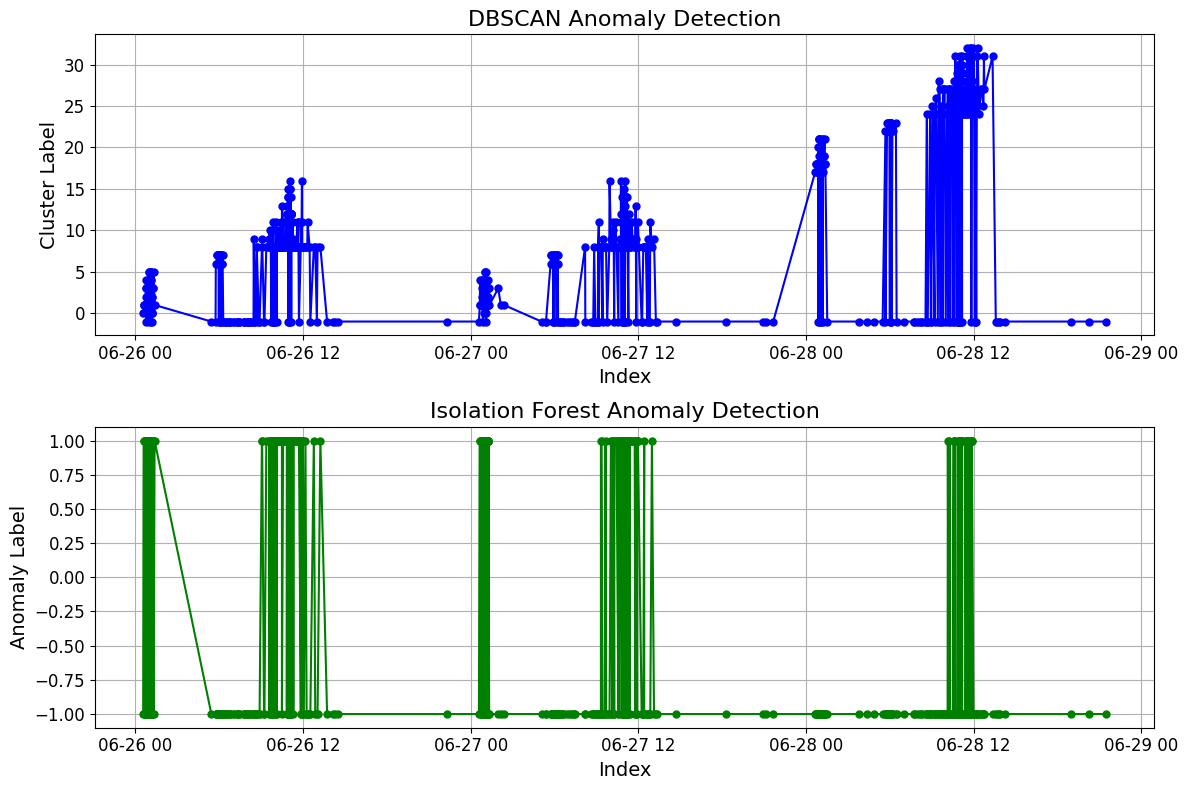

In [66]:
import matplotlib.pyplot as plt

# Create a figure with a specified size
plt.figure(figsize=(12, 8))

# Plot DBSCAN labels
plt.subplot(2, 1, 1)
plt.plot(sample_df.index, clusters, marker='o', linestyle='-', color='b', markersize=5)
plt.title('DBSCAN Anomaly Detection', fontsize=16)
plt.xlabel('Index', fontsize=14)
plt.ylabel('Cluster Label', fontsize=14)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Plot Isolation Forest labels
plt.subplot(2, 1, 2)
plt.plot(sample_df.index, iso_labels, marker='o', linestyle='-', color='g', markersize=5)
plt.title('Isolation Forest Anomaly Detection', fontsize=16)
plt.xlabel('Index', fontsize=14)
plt.ylabel('Anomaly Label', fontsize=14)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()


In [67]:
from sklearn.metrics import silhouette_score

# Calculate Silhouette Coefficient
silhouette_avg = silhouette_score(scaled_data, clusters)
print(f"Silhouette Coefficient: {silhouette_avg}")

Silhouette Coefficient: 0.19495696086678016


In [68]:
from sklearn.metrics import silhouette_score

# Calculate Silhouette Coefficient
silhouette_isolation_f = silhouette_score(scaled_data, iso_labels)
print(f"Silhouette Coefficient: {silhouette_isolation_f}")

Silhouette Coefficient: 0.05471014374108211
